In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import seaborn as sns
from collections import Counter

import sys
sys.path.append('..')
from configuration import STConfig
from wrappers.sdata_initalizer import SDataInitalizer
from wrappers.sdata_customizer import SDataCustomizer

import anndata as ad

from utils.utils_colors import cell_color_dict
from utils.utils_geom import align_sample_polygons

### Reading Consolidated Anndata object

In [2]:
cfg = STConfig()
adata = ad.read_h5ad(cfg.pth_consol_adata)
adata = adata[adata.obs["cell_status"] != "adipocyte"]
adata

View of AnnData object with n_obs × n_vars = 5776812 × 377
    obs: 'region', 'slide', 'cell_id', 'area', 'cell_status', 'meg_phenotype', 'annotation', 'it_regions', 'mutation_status', 'run', 'study_id', 'diagnosis', 'diagnosis2', 'broad_diagnosis', 'SCT_snn_res.0.3', 'clusters', 'clusters_w_megs', 'new_clusters', 'new_clusters_w_megs', 'region_name', 'nearest_bone', 'distance_to_bone', 'bone_region', 'nearest_niche', 'distance_to_niche', 'obj.cell_id', 'obj.august_clusters_1', 'obj.anno_1', 'obj.anno_2', 'obj.anno_3', 'obj.anno_4', 'obj.anno_5', 'obj.anno_1_w_megs', 'obj.anno_2_w_megs', 'obj.anno_3_w_megs', 'obj.anno_4_w_megs', 'obj.anno_5_w_megs', 'extra_new_cell_status', 'batch'
    obsm: 'spatial'

In [3]:
# reading cell annotation 
skey = 'sample_id'
dkey = 'diagnosis2'
cell_type_col = 'obj.anno_3_w_megs_w_stromal'
annot_df = pd.read_csv(cfg.pth_cell_annotations_final)
annot_df[skey] = annot_df['cell_id'].str[-8:]
annot_df = annot_df.loc[:, [skey,'cell_id' ,cell_type_col]]
annot_df.index = annot_df['cell_id'].tolist()
annot_df.drop(columns=['cell_id'], inplace=True)
annot_df.head(2)

/tmp/slurm-1682702/ipykernel_791351/2546719193.py:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  annot_df = pd.read_csv(cfg.pth_cell_annotations_final)


,sample_id,obj.anno_3_w_megs_w_stromal
aaabbbkl-1_10693_R2,10693_R2,DC
aaabpmkp-1_10693_R2,10693_R2,Erythroid


In [4]:
adata.obs = adata.obs.merge(annot_df, left_index=True, right_index=True)

In [5]:
diagnosis_order = ["Normal", "ET", "PV", "PrePMF", "MF"]
diagnosis_color_palette = ["limegreen", "deepskyblue", "red", "mediumorchid", "darkorange"]

In [6]:
df = adata.obs[[skey, cell_type_col, dkey]].dropna()
df = df[~df[cell_type_col].isin(['CD69'])]

### Plotting Atlas Level Cell counts

In [7]:
color_dict = {
    k: mcolors.to_rgba(v) 
    for k, v in cell_color_dict.items()
}

counts_df = df[~df[cell_type_col].isin(['CD69'])]
counts_df = counts_df[cell_type_col].value_counts().reset_index()
counts_df.head(3)

,obj.anno_3_w_megs_w_stromal,count
0,Erythroid,950020
1,Monocyte,679232
2,Myeloid,526470


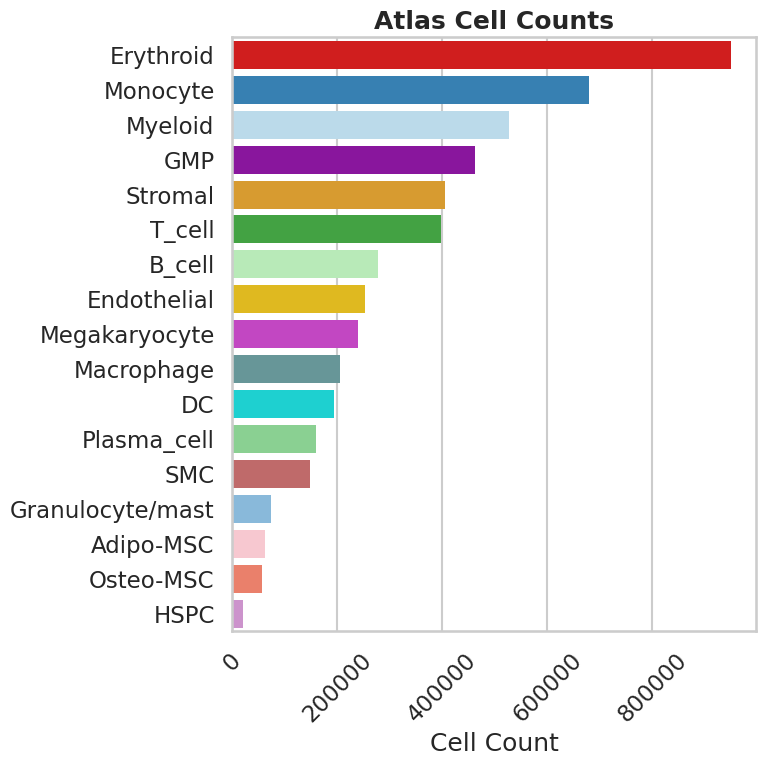

In [19]:
sns.set_theme(style="whitegrid")
sns.set_context("talk")
plt.figure(figsize=(8, 8))  # Taller figure = thicker bars
sns.barplot(
    x="count", y=cell_type_col, data=counts_df,
    palette=color_dict,
    order=counts_df[cell_type_col],  # Keep order after sorting
    linewidth=0
)

plt.xlabel("Cell Count")
plt.ylabel("")
plt.title("Atlas Cell Counts", loc="center", weight="bold")
plt.xticks(rotation=45)
plt.tight_layout()

### Plotting Cellular Abundance per Sample Across Conditions

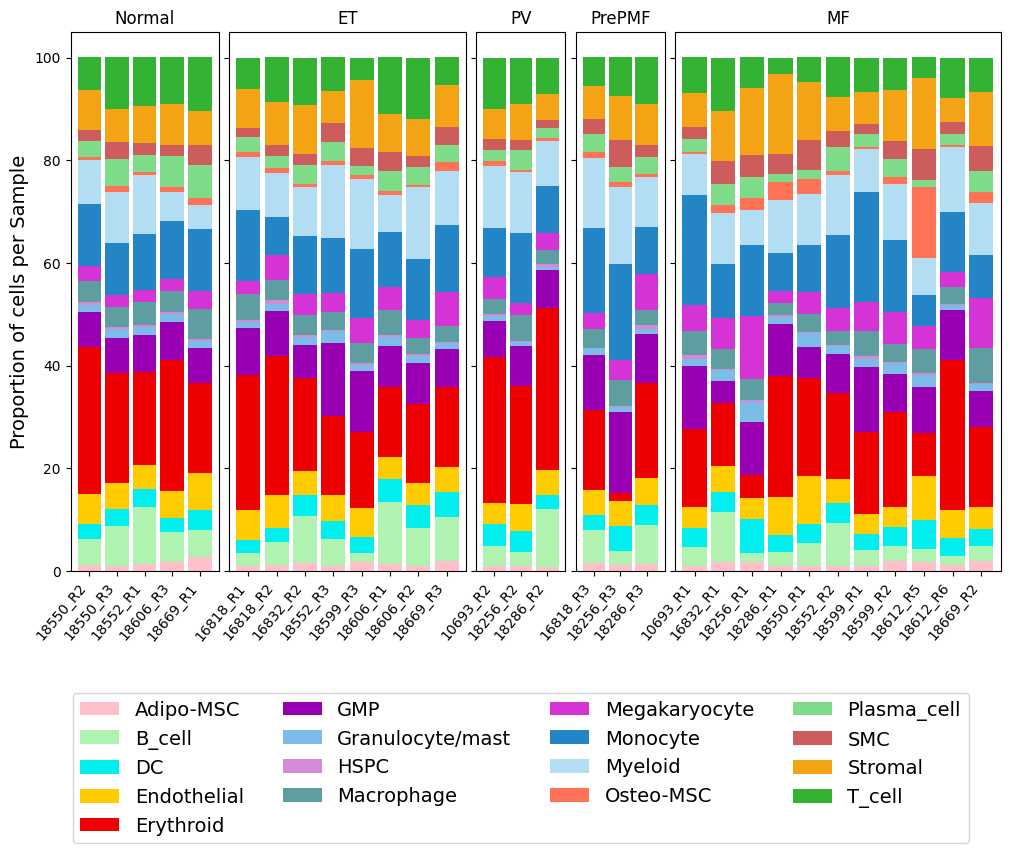

In [20]:
sns.reset_orig()   
plt.rcdefaults()  
%matplotlib inline     

# Some patients contibute more than one sections bagging those
patients_dict = {
    "18612_R1": "18612_R5",
    "18612_R4": "18612_R5",
    "18612_R2": "18612_R6",
    "18612_R3": "18612_R6"
}

df[skey] = df[skey].replace(patients_dict)

props = df.groupby(skey)[cell_type_col].value_counts(normalize=True).reset_index()
map_dict = df.set_index(skey)[dkey].to_dict()
props[dkey] = props[skey].map(map_dict)
props['proportion'] *= 100

counter = Counter(map_dict.values())
ordered_counts = {diag: counter[diag]/2.5 for diag in diagnosis_order}
widths = list(ordered_counts.values())

fig = plt.figure(figsize=(sum(widths), 7))
gs = gridspec.GridSpec(1, len(widths), width_ratios=widths)
gs.update(wspace=0.06)


label_order = list(color_dict.keys())
first_ax = fig.add_subplot(gs[0, 0])

axes = [first_ax] + [fig.add_subplot(gs[0, i], sharey=first_ax) for i in range(1, len(widths))]


for idx, diag in enumerate(diagnosis_order):
    ax = axes[idx]

    sel_df = props[props[dkey] == diag]

    if sel_df.empty:
        ax.set_title(f"{diag}\n(no data)")
        ax.set_xticks([])
        continue

    pivot = sel_df.pivot_table(
        index=skey,
        columns=cell_type_col,
        values='proportion',
        fill_value=0
        )
    # default cell ordering is used for plotting in paper figs.
    # pivot = pivot.reindex(columns=label_order)  
    pivot.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        legend=False,
        color=[color_dict[c] for c in pivot.columns],
        width=0.85
        )

    ax.set_title(diag)
    ax.set_xlabel("")
    ax.set_ylim(0, 105)      
    ax.tick_params(axis='y', labelleft=(idx == 0))  # show y labels only on first panel
    ax.set_ylabel("Proportion of cells per Sample" if idx == 0 else "", fontdict={'size':14})
    ax.set_xticklabels([str(x) for x in pivot.index], rotation=50, ha='right')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.05), fontsize=14)
plt.show()
